# Лабораторна робота №2. Реалiзацiя базової архiтектури згорткової нейронної мережi для вирiшення задачi класифiкацiї чи регресiї

**Виконала** студентка групи КІ-51мп Додонова Марія

**Мета:** Навчитися будувати архiтектури простих згорткових нейронних мереж, дослiдити принципи роботи їхнiх базових шарiв (згортка, пулiнг, повнозв’язний), а також отримати практичнi навички у налаштуваннi гiперпараметрiв та аналiзi процесу навчання моделi.

## Порядок виконання

1. Обрати фреймворк для виконання роботи: `tensorflow` чи `pytorch`.

2. Обрати датасет для вирiшення задачi класифiкацiї зображень. Рекомендується використовувати один з наступних, оскiльки вони дозволять повторно використовувати код та результати у наступних лабораторних роботах:
* **Fashion MNIST:** Набiр з 70,000 зображень одягу (28x28, чорно-бiлi), роздiлених на 10 класiв. Гарна замiна для класичного MNIST.
* **CIFAR-10:** Набiр з 60,000 кольорових зображень (32x32) для 10 класiв (лiтаки, автомобiлi, птахи тощо). Бiльш складний, нiж Fashion MNIST, i краще пiдходить для демонстрацiї переваг CNN.
* **CIFAR-100:** Схожий на CIFAR-10, але має 100 класiв. Значно складнiший i вимагає бiльш продуманої архiтектури та довшого навчання.

3. Завантажити, виконати попередню обробку та роздiлити датасет на тренувальну, валiдацiйну та тестову вибiрки. Попередня обробка повинна включати нормалiзацiю/стандартизацiю значень пiкселiв. Додатково можна застосувати аугментацiю даних (випадковi повороти, зсуви, вiддзеркалення) для тренувальної вибiрки.

4. Обрати базову просту архiтектуру згорткової мережi: LeNet5, AlexNet, або побудувати власну, що складається з 2-3 згорткових блокiв (Conv + ReLU + Pool) та 1-2 повнозв’язних шарiв.

5. Реалiзувати вибрану архiтектуру на обраному фреймворцi з використанням стандартних вбудованих шарiв, оптимiзаторiв та функцiй втрат.

6. Навчити мережу на завантаженому датасетi. Спробуйте використати рiзнi гiперпараметри:
* **Оптимiзатор:** Adam, SGD with momentum.
* **Швидкiсть навчання (learning rate):** Спробуйте кiлька значень (наприклад, 0.001, 0.01).
* **Розмiр батчу (batch size):** Наприклад, 32, 64, 128.

7. Побудувати графiки залежностi функцiї втрат (loss) та точностi (accuracy) вiд епохи навчання для тренувальної та валiдацiйної вибiрок. Проаналiзувати графiки на наявнiсть перенавчання (overfitting) або недонавчання (underfitting). Зробити висновки щодо впливу гiперпараметрiв на результат.

## Виконання роботи

### 1. Обрати фреймворк для виконання роботи: `tensorflow` чи `pytorch`.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from src.models.lenet import LeNet5
from src.trainer import Trainer
from src.plot_tools import plot_history

DATA_PATH = "data"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_EPOCHS = 10

print(f"Using device: {DEVICE}")

Using device: cuda


### 2. Обрати датасет для вирiшення задачi класифiкацiї зображень. Рекомендується використовувати один з наступних, оскiльки вони дозволять повторно використовувати код та результати у наступних лабораторних роботах:
* **Fashion MNIST:** Набiр з 70,000 зображень одягу (28x28, чорно-бiлi), роздiлених на 10 класiв. Гарна замiна для класичного MNIST.
* **CIFAR-10:** Набiр з 60,000 кольорових зображень (32x32) для 10 класiв (лiтаки, автомобiлi, птахи тощо). Бiльш складний, нiж Fashion MNIST, i краще пiдходить для демонстрацiї переваг CNN.
* **CIFAR-100:** Схожий на CIFAR-10, але має 100 класiв. Значно складнiший i вимагає бiльш продуманої архiтектури та довшого навчання.

### 3. Завантажити, виконати попередню обробку та роздiлити датасет на тренувальну, валiдацiйну та тестову вибiрки. Попередня обробка повинна включати нормалiзацiю/стандартизацiю значень пiкселiв. Додатково можна застосувати аугментацiю даних (випадковi повороти, зсуви, вiддзеркалення) для тренувальної вибiрки.

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2470, 0.2435, 0.2616)
    )
])

# Load train and test splits
train_dataset = datasets.CIFAR10(
    root=DATA_PATH,
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root=DATA_PATH,
    train=False,
    download=True,
    transform=transform
)

# Split train into train and validation
train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])

### 4. Обрати базову просту архiтектуру згорткової мережi: LeNet5, AlexNet, або побудувати власну, що складається з 2-3 згорткових блокiв (Conv + ReLU + Pool) та 1-2 повнозв’язних шарiв.

### 5. Реалiзувати вибрану архiтектуру на обраному фреймворцi з використанням стандартних вбудованих шарiв, оптимiзаторiв та функцiй втрат.

### 6. Навчити мережу на завантаженому датасетi. Спробуйте використати рiзнi гiперпараметри:
* **Оптимiзатор:** Adam, SGD with momentum.
* **Швидкiсть навчання (learning rate):** Спробуйте кiлька значень (наприклад, 0.001, 0.01).
* **Розмiр батчу (batch size):** Наприклад, 32, 64, 128.

Training LeNet5:
PARAMETERS: batch_size=32, lr=0.001
Epoch [ 1/10]: Train Loss: 2.0147, Val Loss: 1.8422, Train Accuracy: 0.2399, Val Accuracy: 0.3082.
Epoch [ 2/10]: Train Loss: 1.7440, Val Loss: 1.6966, Train Accuracy: 0.3472, Val Accuracy: 0.3731.
Epoch [ 3/10]: Train Loss: 1.5942, Val Loss: 1.5244, Train Accuracy: 0.4112, Val Accuracy: 0.4341.
Epoch [ 4/10]: Train Loss: 1.4788, Val Loss: 1.4311, Train Accuracy: 0.4547, Val Accuracy: 0.4754.
Epoch [ 5/10]: Train Loss: 1.4097, Val Loss: 1.3728, Train Accuracy: 0.4830, Val Accuracy: 0.4950.
Epoch [ 6/10]: Train Loss: 1.3654, Val Loss: 1.3742, Train Accuracy: 0.5025, Val Accuracy: 0.4977.
Epoch [ 7/10]: Train Loss: 1.3285, Val Loss: 1.3106, Train Accuracy: 0.5161, Val Accuracy: 0.5205.
Epoch [ 8/10]: Train Loss: 1.2975, Val Loss: 1.3337, Train Accuracy: 0.5291, Val Accuracy: 0.5084.
Epoch [ 9/10]: Train Loss: 1.2619, Val Loss: 1.2904, Train Accuracy: 0.5429, Val Accuracy: 0.5306.
Epoch [10/10]: Train Loss: 1.2309, Val Loss: 1.2560, Tra

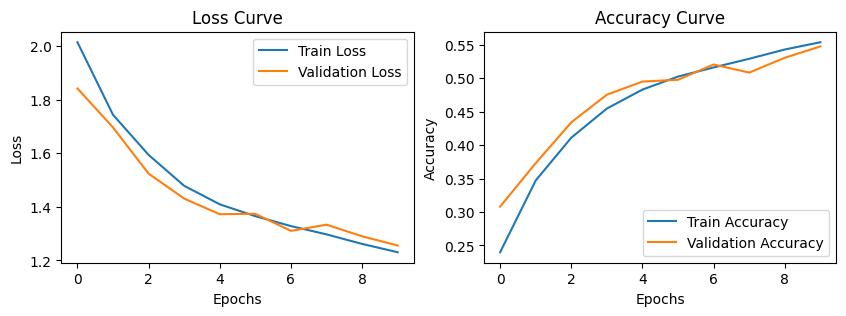

PARAMETERS: batch_size=32, lr=0.01
Epoch [ 1/10]: Train Loss: 1.8817, Val Loss: 1.6337, Train Accuracy: 0.2986, Val Accuracy: 0.3915.
Epoch [ 2/10]: Train Loss: 1.5941, Val Loss: 1.6214, Train Accuracy: 0.4144, Val Accuracy: 0.4195.
Epoch [ 3/10]: Train Loss: 1.5007, Val Loss: 1.4643, Train Accuracy: 0.4518, Val Accuracy: 0.4554.
Epoch [ 4/10]: Train Loss: 1.4292, Val Loss: 1.4422, Train Accuracy: 0.4823, Val Accuracy: 0.4705.
Epoch [ 5/10]: Train Loss: 1.3887, Val Loss: 1.4327, Train Accuracy: 0.4990, Val Accuracy: 0.4901.
Epoch [ 6/10]: Train Loss: 1.3413, Val Loss: 1.4191, Train Accuracy: 0.5178, Val Accuracy: 0.4945.
Epoch [ 7/10]: Train Loss: 1.3134, Val Loss: 1.3708, Train Accuracy: 0.5277, Val Accuracy: 0.5076.
Epoch [ 8/10]: Train Loss: 1.2797, Val Loss: 1.4024, Train Accuracy: 0.5435, Val Accuracy: 0.5001.
Epoch [ 9/10]: Train Loss: 1.2545, Val Loss: 1.3612, Train Accuracy: 0.5528, Val Accuracy: 0.5176.
Epoch [10/10]: Train Loss: 1.2344, Val Loss: 1.3516, Train Accuracy: 0.559

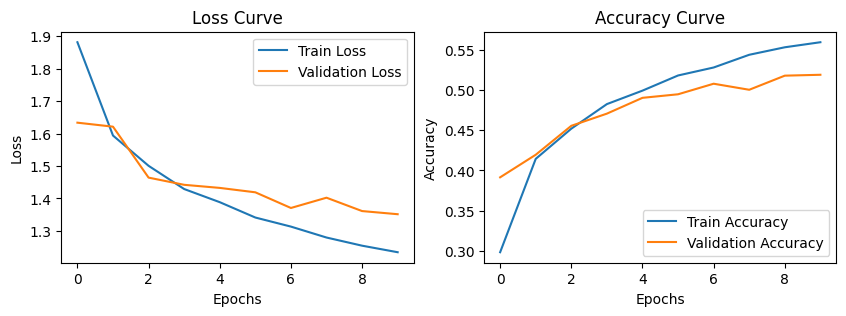

PARAMETERS: batch_size=64, lr=0.001
Epoch [ 1/10]: Train Loss: 2.0592, Val Loss: 1.9321, Train Accuracy: 0.2217, Val Accuracy: 0.2859.
Epoch [ 2/10]: Train Loss: 1.8886, Val Loss: 1.8397, Train Accuracy: 0.3008, Val Accuracy: 0.3191.
Epoch [ 3/10]: Train Loss: 1.7548, Val Loss: 1.6943, Train Accuracy: 0.3598, Val Accuracy: 0.3830.
Epoch [ 4/10]: Train Loss: 1.6213, Val Loss: 1.5636, Train Accuracy: 0.4036, Val Accuracy: 0.4237.
Epoch [ 5/10]: Train Loss: 1.5463, Val Loss: 1.5110, Train Accuracy: 0.4290, Val Accuracy: 0.4423.
Epoch [ 6/10]: Train Loss: 1.4896, Val Loss: 1.5091, Train Accuracy: 0.4496, Val Accuracy: 0.4435.
Epoch [ 7/10]: Train Loss: 1.4478, Val Loss: 1.4286, Train Accuracy: 0.4642, Val Accuracy: 0.4770.
Epoch [ 8/10]: Train Loss: 1.4092, Val Loss: 1.4312, Train Accuracy: 0.4799, Val Accuracy: 0.4726.
Epoch [ 9/10]: Train Loss: 1.3743, Val Loss: 1.3714, Train Accuracy: 0.4970, Val Accuracy: 0.5032.
Epoch [10/10]: Train Loss: 1.3470, Val Loss: 1.3475, Train Accuracy: 0.50

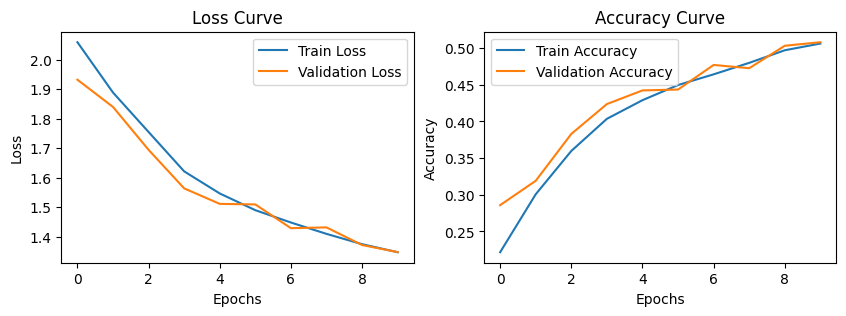

PARAMETERS: batch_size=64, lr=0.01
Epoch [ 1/10]: Train Loss: 1.9637, Val Loss: 1.7550, Train Accuracy: 0.2583, Val Accuracy: 0.3399.
Epoch [ 2/10]: Train Loss: 1.6406, Val Loss: 1.5462, Train Accuracy: 0.3953, Val Accuracy: 0.4278.
Epoch [ 3/10]: Train Loss: 1.4903, Val Loss: 1.4620, Train Accuracy: 0.4545, Val Accuracy: 0.4620.
Epoch [ 4/10]: Train Loss: 1.4109, Val Loss: 1.3910, Train Accuracy: 0.4859, Val Accuracy: 0.4915.
Epoch [ 5/10]: Train Loss: 1.3474, Val Loss: 1.3663, Train Accuracy: 0.5110, Val Accuracy: 0.5058.
Epoch [ 6/10]: Train Loss: 1.3003, Val Loss: 1.3517, Train Accuracy: 0.5325, Val Accuracy: 0.5134.
Epoch [ 7/10]: Train Loss: 1.2431, Val Loss: 1.3015, Train Accuracy: 0.5568, Val Accuracy: 0.5328.
Epoch [ 8/10]: Train Loss: 1.2086, Val Loss: 1.3224, Train Accuracy: 0.5683, Val Accuracy: 0.5226.
Epoch [ 9/10]: Train Loss: 1.1746, Val Loss: 1.3219, Train Accuracy: 0.5803, Val Accuracy: 0.5296.
Epoch [10/10]: Train Loss: 1.1385, Val Loss: 1.2979, Train Accuracy: 0.594

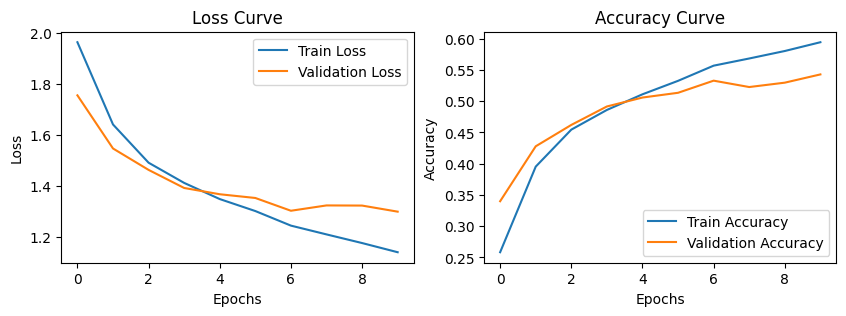

PARAMETERS: batch_size=128, lr=0.001
Epoch [ 1/10]: Train Loss: 2.1352, Val Loss: 1.9767, Train Accuracy: 0.1869, Val Accuracy: 0.2645.
Epoch [ 2/10]: Train Loss: 1.8971, Val Loss: 1.8235, Train Accuracy: 0.2944, Val Accuracy: 0.3279.
Epoch [ 3/10]: Train Loss: 1.7767, Val Loss: 1.7297, Train Accuracy: 0.3389, Val Accuracy: 0.3588.
Epoch [ 4/10]: Train Loss: 1.6937, Val Loss: 1.6509, Train Accuracy: 0.3731, Val Accuracy: 0.3874.
Epoch [ 5/10]: Train Loss: 1.6324, Val Loss: 1.6017, Train Accuracy: 0.3972, Val Accuracy: 0.4161.
Epoch [ 6/10]: Train Loss: 1.5889, Val Loss: 1.5654, Train Accuracy: 0.4147, Val Accuracy: 0.4261.
Epoch [ 7/10]: Train Loss: 1.5506, Val Loss: 1.5277, Train Accuracy: 0.4296, Val Accuracy: 0.4448.
Epoch [ 8/10]: Train Loss: 1.5164, Val Loss: 1.4915, Train Accuracy: 0.4452, Val Accuracy: 0.4538.
Epoch [ 9/10]: Train Loss: 1.4881, Val Loss: 1.4761, Train Accuracy: 0.4556, Val Accuracy: 0.4645.
Epoch [10/10]: Train Loss: 1.4622, Val Loss: 1.4479, Train Accuracy: 0.4

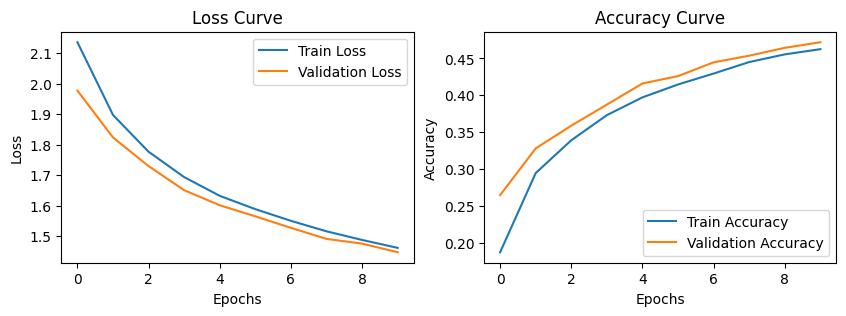

PARAMETERS: batch_size=128, lr=0.01
Epoch [ 1/10]: Train Loss: 1.9113, Val Loss: 1.5743, Train Accuracy: 0.2868, Val Accuracy: 0.4218.
Epoch [ 2/10]: Train Loss: 1.5179, Val Loss: 1.4327, Train Accuracy: 0.4412, Val Accuracy: 0.4753.
Epoch [ 3/10]: Train Loss: 1.3728, Val Loss: 1.3677, Train Accuracy: 0.5044, Val Accuracy: 0.5027.
Epoch [ 4/10]: Train Loss: 1.2732, Val Loss: 1.2762, Train Accuracy: 0.5445, Val Accuracy: 0.5387.
Epoch [ 5/10]: Train Loss: 1.1776, Val Loss: 1.2535, Train Accuracy: 0.5815, Val Accuracy: 0.5531.
Epoch [ 6/10]: Train Loss: 1.1204, Val Loss: 1.2475, Train Accuracy: 0.6001, Val Accuracy: 0.5616.
Epoch [ 7/10]: Train Loss: 1.0604, Val Loss: 1.1981, Train Accuracy: 0.6242, Val Accuracy: 0.5781.
Epoch [ 8/10]: Train Loss: 1.0000, Val Loss: 1.1912, Train Accuracy: 0.6452, Val Accuracy: 0.5863.
Epoch [ 9/10]: Train Loss: 0.9552, Val Loss: 1.2186, Train Accuracy: 0.6619, Val Accuracy: 0.5824.
Epoch [10/10]: Train Loss: 0.9129, Val Loss: 1.1880, Train Accuracy: 0.67

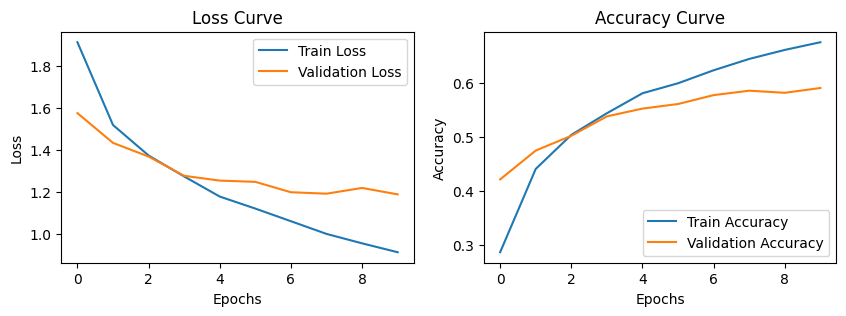

Finished Training!


In [3]:
criterion = nn.CrossEntropyLoss()

print("Training LeNet5:")

for batch_size in [32, 64, 128]:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True)

    for lr in [0.001, 0.01]:
        print(f"PARAMETERS: batch_size={batch_size}, lr={lr}")
        model = LeNet5(in_channels=3, num_classes=10, in_size=(32, 32))
        optimizer = optim.Adam(model.parameters(), lr=lr)
        trainer = Trainer(model, optimizer, criterion, device=DEVICE)

        history = trainer.train(NUM_EPOCHS, train_loader, val_loader)
        print("Test results:", end=" ")
        trainer.test(test_loader)
        plot_history(history)

print("Finished Training!")

### 7. Побудувати графiки залежностi функцiї втрат (loss) та точностi (accuracy) вiд епохи навчання для тренувальної та валiдацiйної вибiрок. Проаналiзувати графiки на наявнiсть перенавчання (overfitting) або недонавчання (underfitting). Зробити висновки щодо впливу гiперпараметрiв на результат.

Проаналізувавши графіки loss та accuracy для різних параметрів, можна зробити висновок, що найкраще мережа працює при застосуванні параметрів `batch_size=128` та `lr=0.001`. Також хорошою комбінацією параметрів є `batch_size=64` та `lr=0.001`.

Перенавчання спостерігається при використанні більшої швидкості навчання. Графіки для менших розмірів батчу свідчать про менш стабільне тренування (присутні скачки валідаційних кривих). Найкращі показники точності на тестовому наборі даних продемонструвала комбінація параметрів `batch_size=128` та `lr=0.01`, але на графіках спостерігається перенавчання. Модель, натренована з параметрами `batch_size=128` та `lr=0.001` демонструє найменше значення точності на тестувальному датасеті, але її графіки свідчать про хороше тренування. Зі збільшенням кількості епох результат виявиться кращим.

## Висновок

В ході виконання роботи було завантажено, передоброблено та розділено датасет CIFAR-10 на тренувальну, валідаційну та тестову вибірки, реалізовано архітектуру згорткової нейронної мережі LeNet5. Було навчено мережу на завантаженому датасеті з використанням різних гіперпараметрів та побудовано графіки навчання мережі.

Проаналізувавши графіки loss та accuracy для різних параметрів, можна зробити висновок, що найкраще мережа працює при застосуванні параметрів `batch_size=128` та `lr=0.001`. Також хорошою комбінацією параметрів є `batch_size=64` та `lr=0.001`.